# Vsebina projektne naloge
Cilj projektne naloge je uporabiti in dodatno nadgraditi znanja, ki ste jih osvojili tekom izdelave sprotnih nalog. V sklopu projektne naloge se boste spoprijeli z izzivom regresijskega problema, natančneje z napovedovanjem časovnih vrst. V tem primeru bo šlo za realne meritve kvalitete zraka, vaš cilj pa bo čim natančneje napovedati vrednost parametra pm10.

In [1700]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy.stats import boxcox
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

In [1701]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [1702]:
df = pd.read_csv('data/RV1_SIPIA.csv')

In [1703]:
df.head(10)

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
0,2023-06-23 08:35:00+00:00,46.234818,15.267305,240.0,52.0,40.0,16.0,148.0
1,2023-09-17 07:35:00+00:00,46.234818,15.267305,240.0,11.0,118.0,7.0,135.0
2,2023-02-16 18:15:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
3,2023-02-16 18:35:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
4,2023-02-16 20:35:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0
5,2023-02-16 20:15:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0
6,2023-02-16 23:35:00+00:00,46.234818,15.267305,240.0,47.0,111.0,2.0,118.0
7,2023-02-16 23:15:00+00:00,46.234818,15.267305,240.0,47.0,111.0,2.0,118.0
8,2023-02-16 21:15:00+00:00,46.234818,15.267305,240.0,68.0,102.0,2.0,116.0
9,2023-02-16 21:35:00+00:00,46.234818,15.267305,240.0,68.0,102.0,2.0,116.0


In [1704]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=["Date"], inplace=True)

In [1705]:
def plot_values(x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

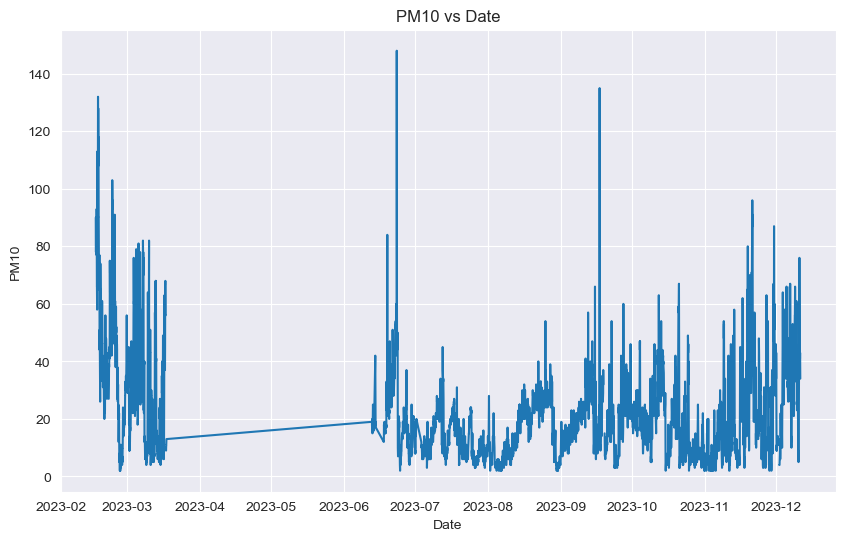

In [1706]:
plot_values('Date', 'PM10')

In [1707]:
# remove data before 2023-06
#df = df[df['Date'] >= '2023-06-01']
# DONT do this

In [1708]:
# remove outliers 
# colud be a good idea
#df = df[df['PM10'] < 120]

In [1709]:
# does not really help
# mean = df['PM10'].mean()
# std = df['PM10'].std()
# 
# z_score = (df['PM10'] - mean) / std
# threshold = 3
# 
# df = df[z_score < threshold]

# Vnos vremenskih podatkov
Dodamo vremenske podatke za te to lokacijo v tem času, ker bi nam mogoče lahko prišlo prav.

In [1710]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00+00:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [1711]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

In [1712]:
df.isnull().sum()

Date           0
Latitude       0
Longitude      0
Altitude       0
NO2          402
PM2.5         67
O3           297
PM10          67
dtype: int64

In [1713]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


# Dodajanje novih značilnic
Z namenom izboljšanja napovedi dodamo nove značilnice, ki bi lahko vplivale na kvaliteto zraka.

In [1714]:
df["PM2.5/N02"] = df["PM2.5"] / df["NO2"]

df["PM2.5/03"] = df["PM2.5"] / df["O3"]

df['Season'] = df['Date'].dt.month.apply(lambda x: 'Winter' if (x == 12 or x <= 2) else
('Spring' if (3 <= x <= 5) else
 ('Summer' if (6 <= x <= 8) else
  ('Autumn' if (9 <= x <= 11) else None))))

df["Season"].astype('category')

df["Weekend"] = df["Date"].dt.dayofweek.apply(lambda x: 1 if (x == 5 or x == 6) else 0)

Kodiranje kategoričnih spremenljivk

In [1715]:
df = pd.get_dummies(df, columns=['Season'])

In [1716]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               402
PM2.5                              67
O3                                297
PM10                               67
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
PM2.5/N02                         403
PM2.5/03                          297
Weekend                             0
Season_Autumn                       0
Season_Sprin

Odstranimo vrstice kjer je PM10 null

In [1717]:
# remove rows where PM10 is null
df = df[df['PM10'].notnull()]

# Zapolnimo manjkajoče vrednosti
Manjkajoče vrednosti zapolnimo z vrednostmi, ki jih napovemo s pomočjo modela.

In [1718]:
cols_to_fill = df.columns[df.isnull().any()].tolist()

In [1719]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [1720]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          0
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [1721]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,103.240981,90.0,0.5,91.0,...,0.4,0.348,0.0,1.014286,0.264237,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True


In [1722]:
np.any(np.isnan(df))

False

# Odkrivanje odvisnosti med spremenljivkam in ciljno spremenljivko

In [1723]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.507048
PM2.5/03                          0.786835
PM2.5/N02                         0.554401
soil_moisture_0_to_7cm (m³/m³)    0.485305
dew_point_2m (°C)                 0.383125
soil_temperature_0_to_7cm (°C)    0.370577
NO2                               0.341258
apparent_temperature (°C)         0.322462
temperature_2m (°C)               0.309983
O3                                0.298618
Name: Information Gain Scores, dtype: float64

<Axes: >

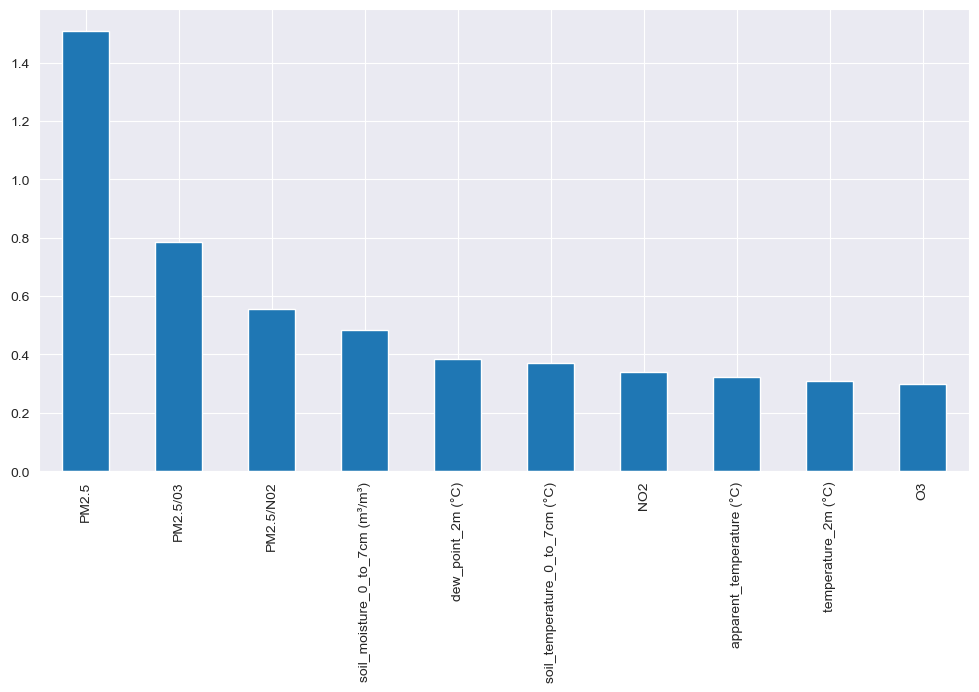

In [1724]:
feature_importances.head(10).plot.bar(figsize=(12, 6))

In [1725]:
top_features = feature_importances.head(3).index.tolist()
print(top_features)

['PM2.5', 'PM2.5/03', 'PM2.5/N02']


# Odpravljanje izkrivljenosti podatkov
- Box-Cox transformacija


In [1726]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Before Box-Cox
    sns.histplot(df[column], ax=ax[0], kde=True)
    ax[0].set_title("Before Box-Cox")

    # transform data
    data, _ = boxcox(df[column])

    # After Box-Cox
    sns.histplot(data, ax=ax[1], kde=True)
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()

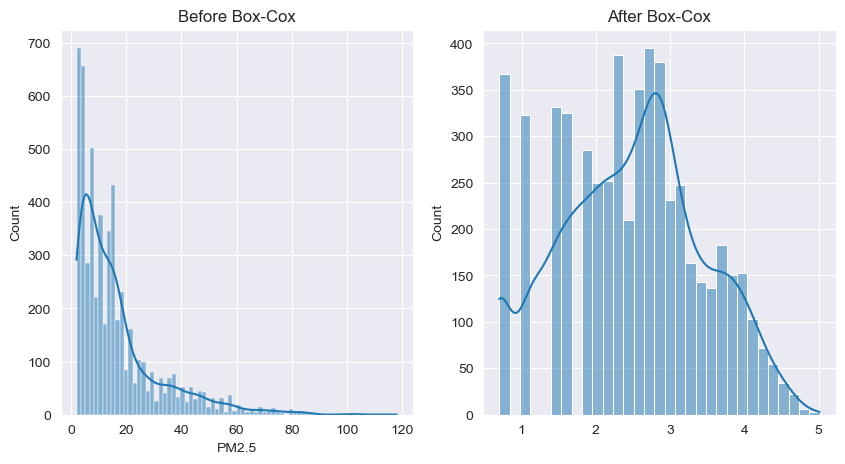

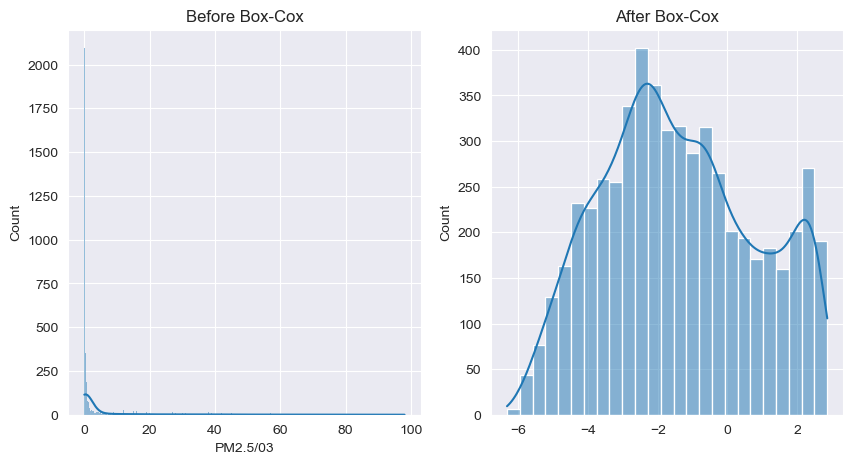

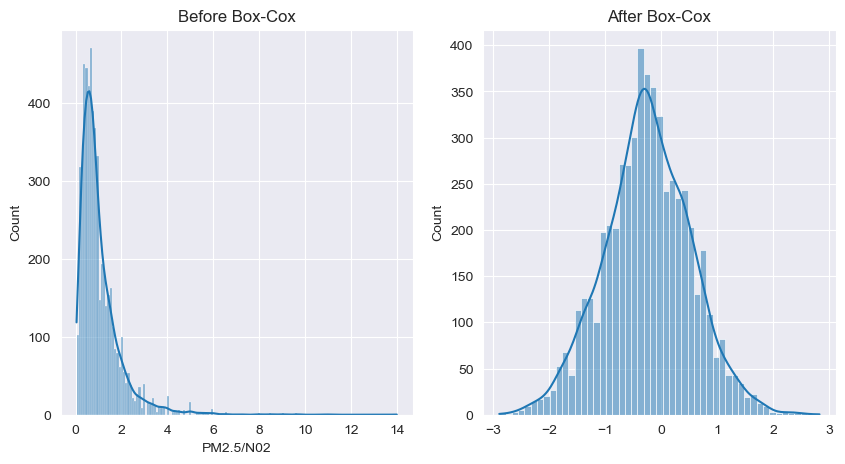

In [1727]:
for feature in top_features:
    boxcox_transform(feature)

# Priprava podatkov za modeliranje

In [1728]:
target = "PM10"
features = [target] + top_features
dataset = df[features]

In [1729]:
dataset.shape

(5558, 4)

In [1730]:
test_split = round(len(dataset) * 0.2)

In [1731]:
train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [1732]:
print(train_data.shape, test_data.shape)

(4446, 4) (1112, 4)


## Normalizacija podatkov

In [1733]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Ustvarjanje vhodno-izhodnih parov
Za napovedovanje časovnih vrst bomo uporabili vhodno-izhodne pare, kjer bo vhod predstavljal n preteklih vrednosti, izhod pa bo predstavljal trenutno vrednost.

In [1734]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [1735]:
# Usage of create_multivariate_time_series function
num_of_days = 1
num_of_measurements_per_day = 10
n_past = num_of_measurements_per_day * num_of_days  # Number of past time steps to consider
target_col = 0  # Index of the target column (PM10) in your dataset
feature_cols = list(range(len(features)))  # All columns used as features

In [1736]:
# Creating input-output pairs using the function
X_train, y_train = create_multivariate_time_series(train_data, n_past, target_col, feature_cols)
X_test, y_test = create_multivariate_time_series(test_data, n_past, target_col, feature_cols)

In [1737]:
print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (4436, 10, 4), y_train: (4436,)
Shape of testing data: X_test: (1102, 10, 4), y_test: (1102,)


In [1738]:
print(X_test.shape, y_test.shape)

(1102, 10, 4) (1102,)


# Ustvarjanje modelov
Ustvarili bomo več različnih modelov in izbrali najboljšega.

In [1739]:
# {'units': 32, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.4, 'batch_size': 128, 'activation': 'tanh'}
# units = 32
# optimizer = 'rmsprop'
# dropout_rate = 0.4
# activation = 'tanh'
# batch_size = 128
# epochs = 100

# Hiperparametri
Iz preteklih zagonov sem ugotovil da se nekateri najboljši parametri ponavljajo.
Najboljši parametri za LSTM za GRU so:
- optimizer: `adam`
- activation: `relu`
- dropout_layer_1: `0.2`
- dropout_layer_2: `0.4`


Iz grafa se razbral, da model pogosto napoveduje premajhne vrednosti zato sem uporabil **mean_squared_logarithmic_error**, ki kaznuje premajhne napovedi bolj kot **mean_squared_error**.


Ostali parametri kot so batch_size, epochs in units so odvisni od modela.

In [1740]:
param_grid = {
   # 'units': [32, 64, 128],
    #'optimizer': ['adam', 'rmsprop', 'SGD', "Adagrad"],
    # 'optimizer': ['adam', 'rmsprop'],
    # 'activation': ['relu', 'sigmoid', 'tanh', "softmax"],
    # 'activation': ['relu', 'softmax', 'tanh'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 25, 30],
    # 'dropout_rate': [0.2, 0.3, 0.4],
    #'dropout_layer_1': [0.1, 0.2, 0.3],
   # 'dropout_layer_2': [0.2, 0.3, 0.4, 0.5],
    #  "loss": ['mean_squared_logarithmic_error', 'mean_squared_error']
}

In [1741]:
def build_lstm(units=32, batch_size=32, epochs=10, dropout_layer_1=0.2,
               dropout_layer_2=0.2, loss='mean_squared_logarithmic_error'):
    model = Sequential(name="LSTM")

    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_1))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_layer_2))

    model.add(LSTM(units=units))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [1742]:
def build_gru(units=32, batch_size=32, epochs=10, dropout_layer_1=0.2,
              dropout_layer_2=0.2, loss='mean_squared_logarithmic_error'):
    model = Sequential(name="GRU")

    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_1))

    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_layer_2))

    model.add(GRU(units=units))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [1743]:
def build_conv_lstm(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    # Define the CNN-LSTM model
    model = Sequential(name="Conv_LSTM")

    # Convolutional layers for feature extraction
    model.add(
        Conv1D(filters=64, kernel_size=3, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM layers for sequence modeling
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))

    # Output layer
    model.add(Dense(units=1))  # Adjust units for your specific output

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [1744]:
def build_advance_conv_lstm(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    # Define the CNN-LSTM model
    model = Sequential(name="Advance_Conv_LSTM")

    # Convolutional layers for feature extraction
    model.add(
        Conv1D(filters=64, kernel_size=3, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM layers for sequence modeling
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dense(units=32, activation=activation))

    # Output layer
    model.add(Dense(units=1))  # Adjust units for your specific output

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [1745]:
def build_advanced_gru( optimizer='adam', activation='relu', loss='mean_squared_logarithmic_error', dropout_layer_1=0.1,
                       dropout_layer_2=0.4):
    model = Sequential(name="Advanced_GRU")

    model.add(GRU(units=512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_1))

    model.add(GRU(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_1))

    model.add(GRU(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_2))

    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(dropout_layer_2))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(dropout_layer_2))

    model.add(GRU(units=32, activation=activation))
    model.add(Dense(units=1))
    
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [1746]:

def build_advanced_lstm(optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_layer_1=0.2,
                        dropout_layer_2=0.4, loss='mean_squared_logarithmic_error'):
    model = Sequential(name="Advance_LSTM")
    
    model.add(LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_1))

    model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_1))

    model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_layer_2))

    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(dropout_layer_2))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(dropout_layer_2))

    model.add(LSTM(units=32,activation=activation))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss=loss)

    return model

In [1747]:
model_fns = [build_advanced_lstm, build_advanced_gru]

In [1748]:
model_names = [build_fn().name for build_fn in model_fns]
model_names

['Advance_LSTM', 'Advanced_GRU']

In [1749]:
best_score = float('-inf')
best_model = None
best_grid_result = None
history = {}
best_models = {}

for idx, create_model_fn in enumerate(model_fns):

    model = KerasRegressor(build_fn=create_model_fn, verbose=0)

    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              scoring='neg_mean_squared_error', cv=3, n_iter=3,
                              random_state=1234)

    grid_result = grid.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    history[model_names[idx]] = grid_result.best_estimator_.model.history.history
    best_models[model_names[idx]] = grid_result.best_estimator_.model

    if grid_result.best_score_ > best_score:
        best_score = grid_result.best_score_
        best_model = grid_result.best_estimator_.model
        best_grid_result = grid_result

print("Best model found:", best_model.name)
print("Best score:", best_score)

Epoch 1/30
24/24 [==============================] - 8s 181ms/step - loss: 0.0042 - val_loss: 0.0075
Epoch 2/30
24/24 [==============================] - 4s 167ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 3/30
24/24 [==============================] - 4s 175ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 4/30
24/24 [==============================] - 5s 189ms/step - loss: 0.0022 - val_loss: 0.0067
Epoch 5/30
24/24 [==============================] - 5s 192ms/step - loss: 0.0020 - val_loss: 0.0070
Epoch 6/30
24/24 [==============================] - 4s 170ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 7/30
24/24 [==============================] - 5s 190ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 8/30
24/24 [==============================] - 5s 201ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 9/30
24/24 [==============================] - 5s 211ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 10/30
24/24 [==============================] - 4s 175ms/step - loss: 0.0017 - val_loss: 0.0051

# Vizualizacija rezultatov in ovrednotenje modelov

In [1750]:
def plot_history(history):
    plt.figure(figsize=(12, 8))
    for name, values in history.items():
        plt.plot(values['loss'], label=name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

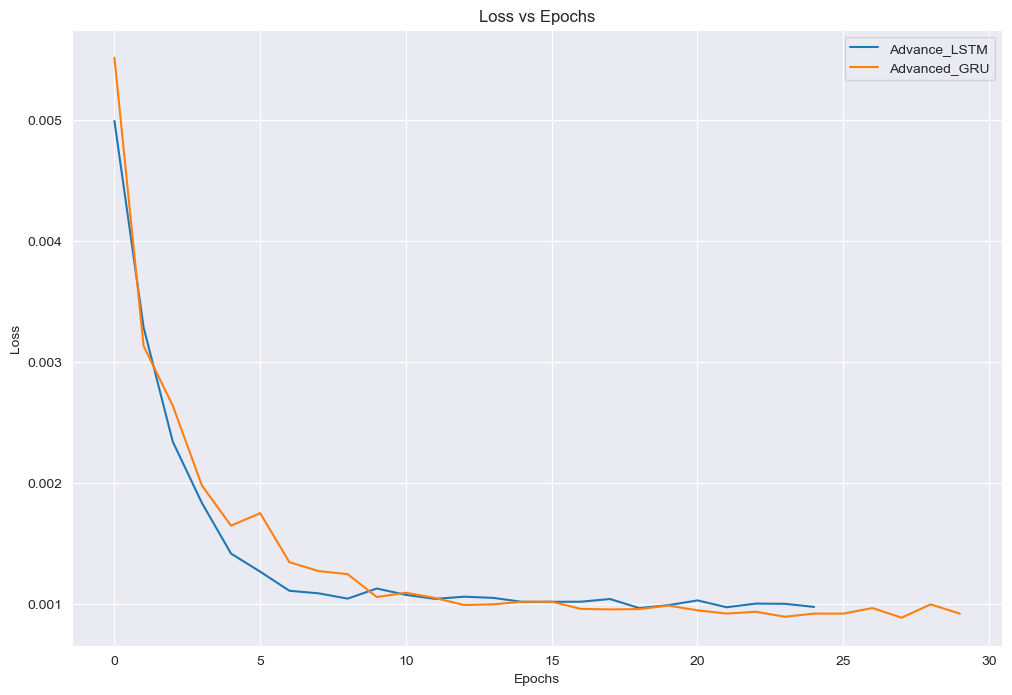

In [1751]:
plot_history(history)

In [1752]:
def plot_loss():
    plt.figure(figsize=(12, 8))
    plt.plot(best_grid_result.best_estimator_.model.history.history['loss'], label='Training Loss')
    plt.plot(best_grid_result.best_estimator_.model.history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

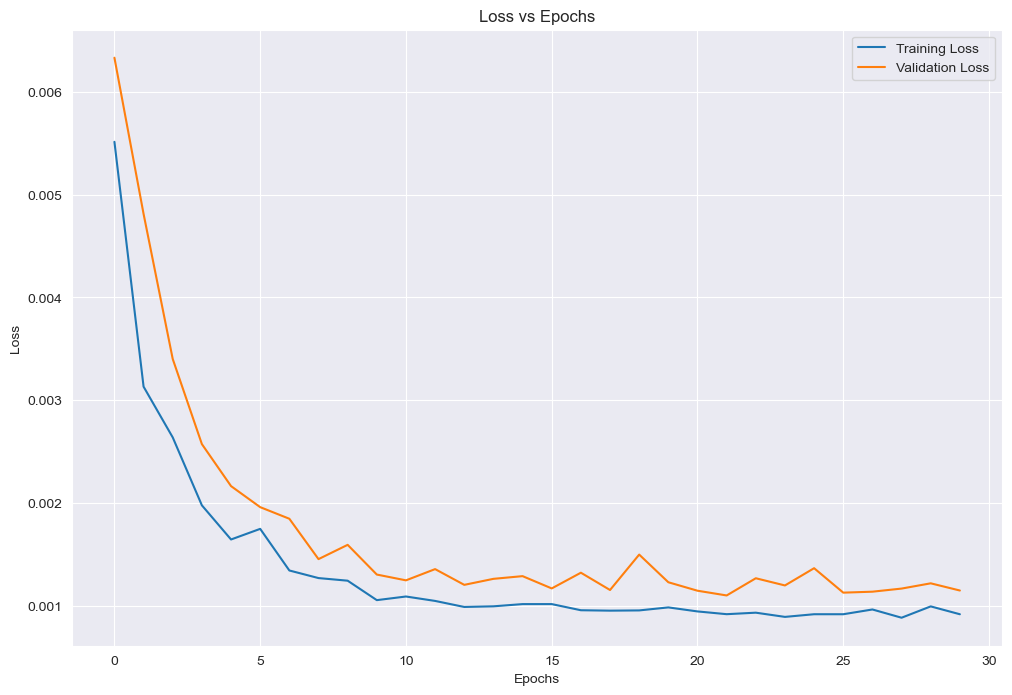

In [1753]:
plot_loss()

In [1754]:
y_test_copies = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copies, (len(y_test), dataset.shape[1])))[:, 0]

In [1755]:
results = {
    'MAE': [],
    'MSE': [],
    'EVS': []
}

for model in best_models.values():
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)

35/35 [==============================] - 2s 23ms/step
Advance_LSTM - MSE: 41.59
Advance_LSTM - MAE: 4.89
Advance_LSTM - EVS: 0.88
--------------------
35/35 [==============================] - 1s 18ms/step
Advanced_GRU - MSE: 36.64
Advanced_GRU - MAE: 4.14
Advanced_GRU - EVS: 0.88
--------------------


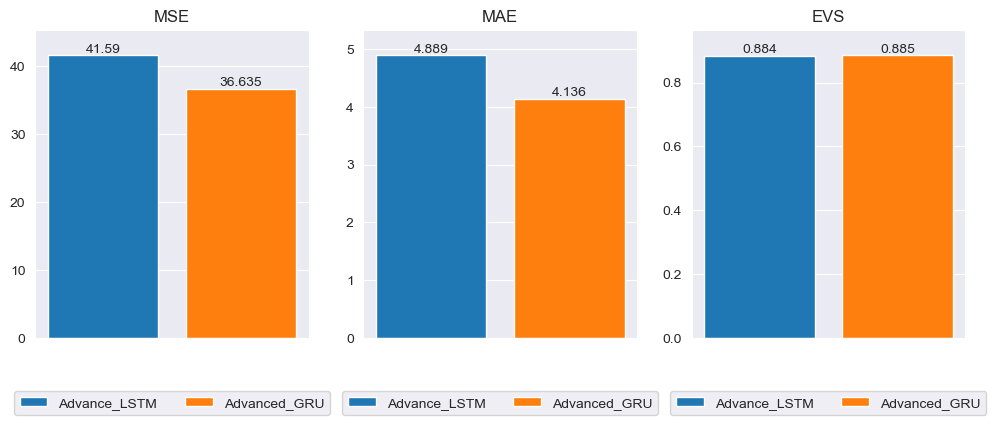

In [1756]:
metrics = ['MSE', 'MAE', 'EVS']

width = 0.8
cols = len(metrics)

fig, axs = plt.subplots(1, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')

    for j, model in enumerate(model_names):
        value = results[metric][j][1]
        if value > max:
            max = value
        ax.bar(j, value, width, label=model)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')

    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [1757]:
prediction = best_model.predict(X_test)

35/35 [==============================] - 1s 23ms/step


In [1758]:
prediction.shape

(1102, 1)

In [1759]:
y_test.shape

(1102,)

In [1760]:
prediction_copies_array = np.repeat(prediction, dataset.shape[1], axis=-1)

In [1761]:
prediction_copies_array.shape

(1102, 4)

In [1762]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), dataset.shape[1])))[:, 0]

In [1763]:
pred.shape

(1102,)

In [1764]:
dates = df['Date'].values

In [1765]:
df_output = pd.DataFrame({"Date":
                              dates[-test_split + n_past:], 'Actual': y_test, 'Predicted': pred})
df_output.head(100)

,Date,Actual,Predicted
0,2023-10-26 01:35:00,8.0,5.374155
1,2023-10-26 02:35:00,6.0,7.920935
2,2023-10-26 03:35:00,6.0,4.893199
3,2023-10-26 04:35:00,5.0,5.646332
4,2023-10-26 05:35:00,5.0,5.463981
...,...,...,...
95,2023-10-30 00:35:00,7.0,6.599117
96,2023-10-30 01:35:00,7.0,6.383639
97,2023-10-30 02:35:00,7.0,6.303708
98,2023-10-30 03:35:00,6.0,8.172589


In [1766]:
def plot_results():
    plt.figure(figsize=(12, 8))
    plt.plot(df_output['Date'], df_output["Actual"], label='Actual')
    plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.title('PM10 vs Time')
    plt.legend()
    plt.show()

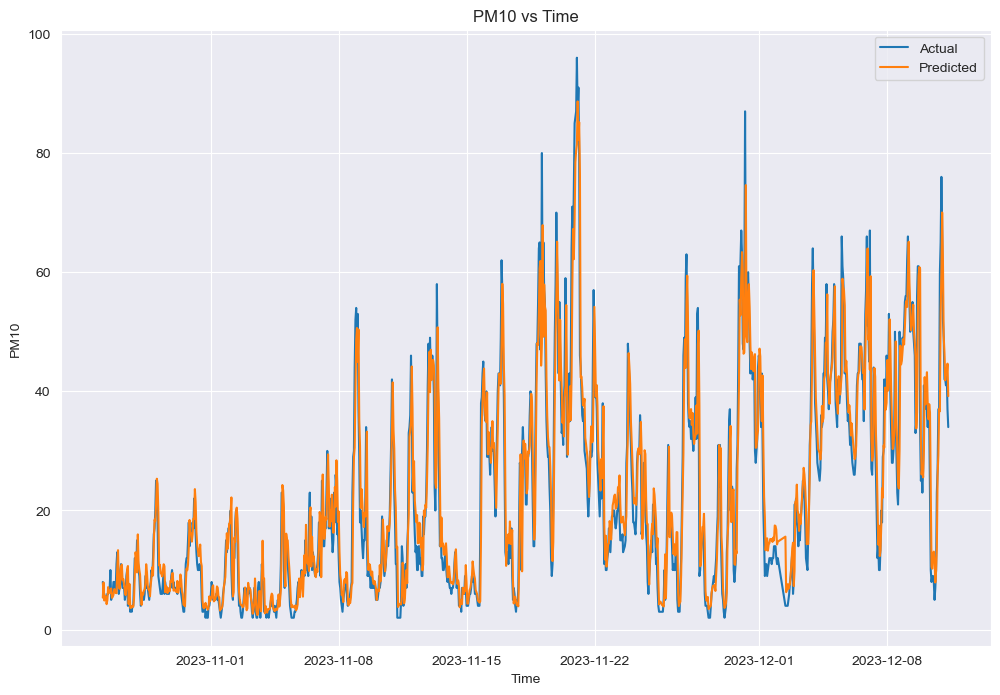

In [1767]:
plot_results()

# Shranjevanje modela in normalizacijskega faktorja

In [1768]:
mse = mean_squared_error(y_test, pred)
mse = format(mse, ".2f")
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 36.64


In [1769]:
model_name = best_model.name

In [1770]:
selected_features = ['PM10'] + top_features
num_of_features = len(selected_features)

In [1771]:
best_model.save(f'out/model_{model_name}_features_{num_of_features}_mse_{mse}.h5')

In [1772]:
with open(f'out/scaler_model_{model_name}_features_{num_of_features}_mse_{mse}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Izvoz podatkov za API

In [1773]:
dataset.to_json('out/data.json', orient='records')